In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
import torch.nn as nn

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla V100-PCIE-32GB


device(type='cuda')

In [4]:
x = torch.tensor([3.0])
x.type()

'torch.cuda.FloatTensor'

In [5]:
def generate_real():
    real_data = torch.tensor([np.random.uniform(0.8, 1.0), 
                              np.random.uniform(0.0, 0.2),
                              np.random.uniform(0.8, 1.0), 
                              np.random.uniform(0.0, 0.2)])
    return real_data

In [6]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(4, 3), 
                                   nn.Sigmoid(),
                                   nn.Linear(3, 1), 
                                   nn.Sigmoid(),
                                  )
        self.model = self.model.cuda()
        
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        self.counter = 0
        self.progress = []
        
        self.outputs = 0
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        self.outputs = self.forward(inputs)
        
        loss = self.loss_function(self.outputs, targets)
        
        self.counter += 1
        if (self.counter %10 == 0):
            self.progress.append(loss.item())
            pass

        if (self.counter % 1000000 == 0):
            print(f"counter = {self.counter}")
            pass        
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5))
        pass

In [7]:
def generate_random(size):
    return torch.rand(size)

In [8]:
D = Discriminator()

for i in range(10000):
    # 실제 데이터 학습
    D.train(generate_real(), torch.Tensor([1.0]))
    # 생성 데이터 학습
    D.train(generate_random(4), torch.Tensor([0.0]))
    pass

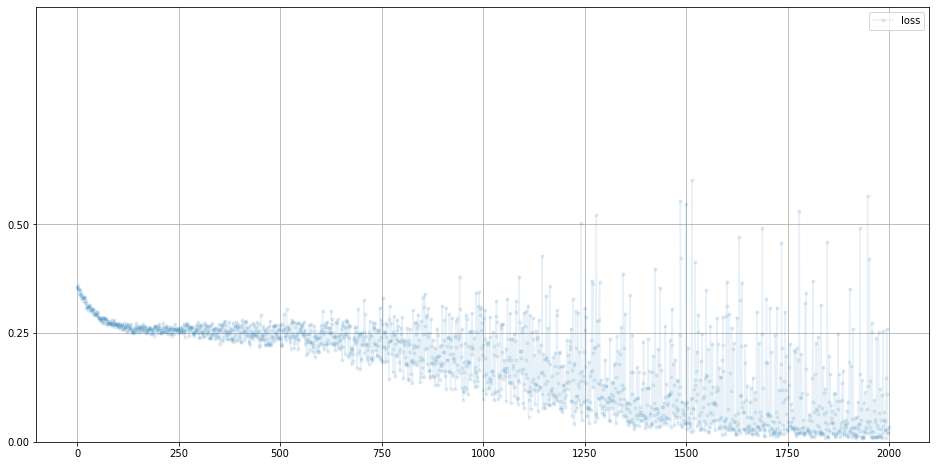

In [9]:
D.plot_progress()

In [10]:
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7944003343582153
0.13235482573509216


In [11]:
class Generator(nn.Module):
    def __init__(self):
        # 부모 클래스 초기화
        super().__init__()
        
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )
        
        # SGD 옵티마이저 설정
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # 진행 측정을 위한 변수 초기화
        self.counter = 0
        self.progress = []
        
        pass
    
    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)
        
        # 판별기로 전달
        d_output = D.forward(g_output)
        
        # 오차 계산
        loss = D.loss_function(d_output, targets)
        
        # 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        # 기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        
        pass
    
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker=".", grid=True, yticks=(0, 0.25, 0.5))
        pass

In [12]:
G = Generator()
G.forward(torch.Tensor([0.5]))

tensor([0.5336, 0.4720, 0.4191, 0.3419], grad_fn=<SigmoidBackward>)

In [13]:
D = Discriminator()
G = Generator()

In [14]:
# %%timeit
image_list = []

# 판별기와 생성기 훈련
for i in range(10000):
    # 1단계: 참에 대해 판별기 훈련
    D.train(generate_real(), torch.Tensor([1.0]))
    
    # 2단계: 거짓에 대해 판별기 훈련
    D.train(G.forward(torch.Tensor([0.5])).detach(), torch.Tensor([0.0]))
    
    # 3단계: 생성기 훈련
    G.train(D, torch.Tensor([0.5]), torch.Tensor([1.0]))
    
    if (i%300 == 0):
        image_list.append(G.forward(torch.Tensor([0.5])).detach().cpu().numpy())
    

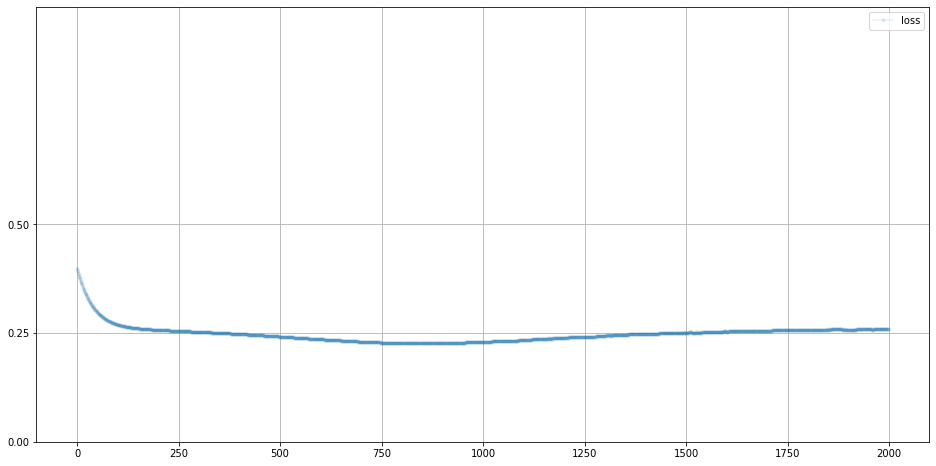

In [15]:
D.plot_progress()

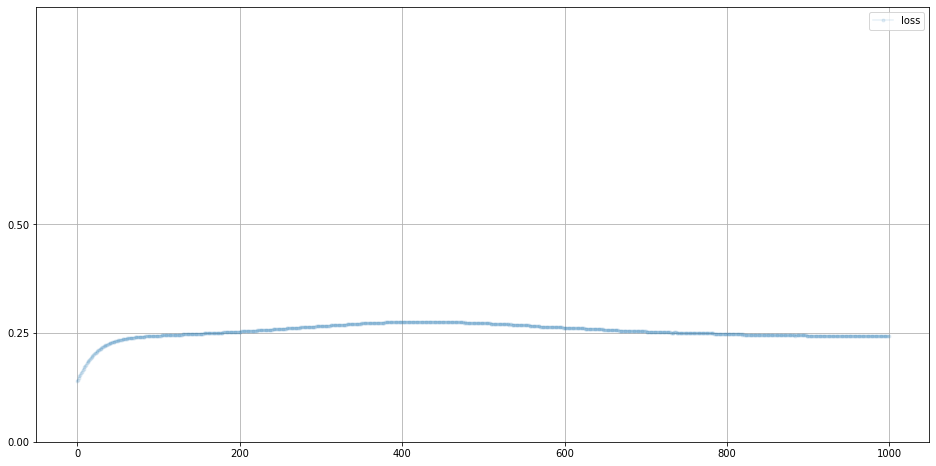

In [16]:
G.plot_progress()

In [17]:
G.forward(torch.Tensor([0.9]))

tensor([0.8976, 0.0591, 0.9385, 0.0420], grad_fn=<SigmoidBackward>)

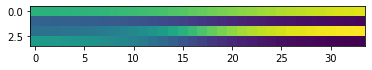

In [18]:
plt.imshow(np.array(image_list).T)

In [ ]:
%%time
image_list = []

# 판별기와 생성기 훈련
for k in range(10000):
    for i in range(10000):
        # 1단계: 참에 대해 판별기 훈련
        D.train(generate_real(), torch.Tensor([1.0]))

        # 2단계: 거짓에 대해 판별기 훈련
        D.train(G.forward(torch.Tensor([0.5])).detach(), torch.Tensor([0.0]))

        # 3단계: 생성기 훈련
        G.train(D, torch.Tensor([0.5]), torch.Tensor([1.0]))

        if (i%300 == 0):
            image_list.append(G.forward(torch.Tensor([0.5])).detach().cpu().numpy())

counter = 1000000
counter = 2000000
counter = 3000000
counter = 4000000
counter = 5000000
counter = 6000000
counter = 7000000
counter = 8000000
counter = 9000000
counter = 10000000
counter = 11000000
counter = 12000000
counter = 13000000
counter = 14000000
counter = 15000000
counter = 16000000
counter = 17000000
counter = 18000000
counter = 19000000
counter = 20000000
counter = 21000000
counter = 22000000
counter = 23000000
counter = 24000000
counter = 25000000
counter = 26000000
counter = 27000000
counter = 28000000
counter = 29000000
counter = 30000000
counter = 31000000
counter = 32000000
counter = 33000000
counter = 34000000
counter = 35000000
counter = 36000000
counter = 37000000
counter = 38000000
counter = 39000000
counter = 40000000
counter = 41000000
counter = 42000000
counter = 43000000
counter = 44000000
counter = 45000000
counter = 46000000
counter = 47000000
